## 导入模块

In [1]:
import os
import random

from PIL import Image
import matplotlib.pyplot as plt
import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.distributions.uniform import Uniform
from torchvision.utils import make_grid
from tensorboardX import SummaryWriter

## 数据加载类

In [2]:
class AnimeDataset(Dataset):
    def __init__(self, root_dir='/home/public/anime-faces', transform=None):
        self.root_dir = root_dir
        self.images = []
        self.get_images()
        self.transform = transform
        
    def get_images(self):
        for category in os.listdir(self.root_dir):
            if os.path.isdir(os.path.join(self.root_dir, category)):
                self.images.extend(map(lambda x: '{}/{}'.format(category, x), 
                                       os.listdir(os.path.join(self.root_dir, category))))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image_path = self.images[index]
        image = Image.open(os.path.join(self.root_dir, image_path))
        if self.transform:
            image = self.transform(image)
        return image
    
    def show_image(self, index):
        plt.imshow(self[index].permute(1, 2, 0))
        

## 可视化初始化

In [3]:
writer = SummaryWriter('./runs')

## 模型(DCGAN)
### Use ReLU activation in generator for all layers except for the output, which uses Tanh.
### Use LeakyReLU activation in the discriminator for all layers.

In [74]:
class Generator(nn.Module):
    
    def __init__(self, in_channels):
        super().__init__()
        self.gen = nn.Sequential(
            self.deconv(in_channels=in_channels, out_channels=1024, padding=0),
            self.deconv(in_channels=1024, out_channels=512, stride=2),
            self.deconv(in_channels=512, out_channels=256, stride=2),
            self.deconv(in_channels=256, out_channels=128, stride=2),
            nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
        self.init_weight()
        
    def forward(self, x):
        return self.gen(x)
        
    def deconv(self, in_channels, out_channels, kernel_size=4, stride=1, padding=1):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
#             nn.BatchNorm2d(out_channels),  # wgan-gp中不能使用batchnorm
            nn.LeakyReLU(0.2, inplace=True)
        )
                
    def init_weight(self, w_mean=0., w_std=0.02, b_mean=1, b_std=0.02):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, mean=w_mean, std=w_std)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight, mean=b_mean, std=b_std)
                nn.init.constant_(m.bias, 0)
        
    
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.dis = nn.Sequential(
            self.conv(in_channels=3, out_channels=128, stride=2),
            self.conv(in_channels=128, out_channels=256, stride=2),
            self.conv(in_channels=256, out_channels=512, stride=2),
            self.conv(in_channels=512, out_channels=1024, stride=2),
            nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=1, padding=0),
#             nn.Sigmoid()   # 不能使用sigmoid
            
        )
        self.linear = nn.Linear(in_features=1024, out_features=1)
    
        self.init_weight()
        
    def forward(self, x):
        x = self.dis(x)
        return x
    
    def conv(self, in_channels, out_channels, kernel_size=4, stride=1, padding=1):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
#             nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
    
    def init_weight(self, w_mean=0., w_std=0.02, b_mean=1, b_std=0.02):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=w_mean, std=w_std)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight, mean=b_mean, std=b_std)
                nn.init.constant_(m.bias, 0)
            
gen = Generator(in_channels=100)
dis = Discriminator()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# writer.add_graph(gen, input_to_model=torch.randn([1, 100, 1, 1]))

## 参数设置

In [75]:
ngpu = 2
IS_PARALLEL = True if ngpu > 1 else False
nz = 100
num_epochs = 100000
batch_size = 64
fixed_noise = torch.randn(16, nz, 1, 1, device=device)

real_label = 1
fake_label = 0

if IS_PARALLEL and torch.cuda.device_count() > 1:
    gen = nn.DataParallel(gen, device_ids=range(ngpu)).to(device)
    dis = nn.DataParallel(dis, device_ids=range(ngpu)).to(device)
    
beta1 = 0.5
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(beta1, 0.999))
dis_optimizer = torch.optim.Adam(dis.parameters(), lr=0.0002, betas=(beta1, 0.999))

lr_scheduler_g = torch.optim.lr_scheduler.StepLR(gen_optimizer, step_size=3, gamma=0.1)
lr_scheduler_d = torch.optim.lr_scheduler.StepLR(dis_optimizer, step_size=3, gamma=0.1)  # 每set_size个epoch更新一次学习率

## 数据处理

In [76]:
t = transforms.Compose(
    [
        transforms.Resize(64),
#         transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
dataset = AnimeDataset(root_dir='/data/LHao/dataset/', transform=t)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
train_loader = iter(train_loader)

## 训练

In [77]:
class Loss:
    def __init__(self, G, D):
        self.G = G
        self.D = D
        
        
class WGAN(Loss):
    def __init__(self, G, D, wgan_epsilon=0.001, wgan_lambda=10.0, wgan_target=1.0, device=torch.device('cpu')):
        super().__init__(G, D)
        self.device = device
        self.wgan_epsilon = wgan_epsilon
        self.wgan_lambda = wgan_lambda
        self.wgan_target = wgan_target
        if device.type == 'cuda':
            self.G = self.G.module
            self.D = self.D.module

    def G_wgan(self, latent_code):
        # Loss_G = -D(G(z))
        fake_images = self.G(latent_code)
        fake_out = self.D(fake_images)
        loss = -torch.mean(fake_out)
        return loss, fake_images
    
    def D_wgan(self, latent_code, real_images):
        # Loss_D = D(G(z)) - D(x) + ε·D(x)^2
        fake_images = self.G(latent_code)
        real_out = self.D(real_images)
        fake_out = self.D(fake_images)
        loss = torch.mean(fake_out) - torch.mean(real_out) + self.wgan_epsilon * torch.square(real_out)
        return loss, fake_images
    
    def D_wgan_gp(self, latent_code, real_images):
        # Loss_D = D(G(z)) - D(x) + η·(||∇T||-1)^2 + ε·D(x)^2
        # D(G(z)) - D(x) + ε·D(x)^2
        wgan_loss, fake_images = self.D_wgan(latent_code, real_images)
        
        # η·(||∇T||-1)^2  梯度惩罚
        alpha = torch.rand(latent_code.shape[0], 1, 1, 1).uniform_(-1, 1).to(self.device)
        interpolates = real_images.data * alpha + (1 - alpha) * fake_images.data  # 真实分布与生成分布之间的插值
        interpolates.requires_grad = True
        interpolates_pred = self.D(interpolates)
        gradients = torch.autograd.grad(outputs=interpolates_pred.sum(), inputs=interpolates, create_graph=True)[0] # 求梯度
#         slopes = torch.sqrt(torch.sum(torch.square(gradients), dim=(1, 2, 3)))# 取模
        slopes = (
                (gradients.view(gradients.size(0), -1).norm(2, dim=1) - 1) ** 2
            ).mean()
        gradient_penalty = 10 * slopes
#         gradient_penalty = (self.wgan_lambda / self.wgan_target ** 2) * torch.mean((slopes - self.wgan_target)**2)
        return (wgan_loss + gradient_penalty).mean()

[999/100000]	Loss_D: -36.4356	Loss_G: 50.0871:   1%|          | 999/100000 [11:48<19:32:07,  1.41it/s] 

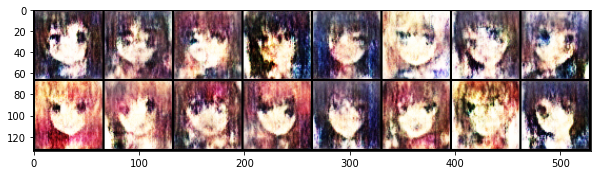

[1999/100000]	Loss_D: -29.6729	Loss_G: 34.7379:   2%|▏         | 1999/100000 [23:38<19:19:35,  1.41it/s]

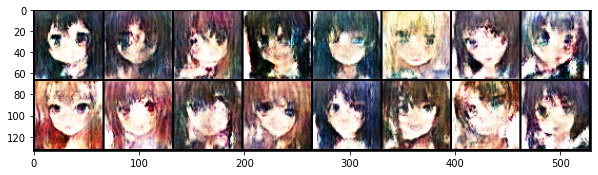

[2999/100000]	Loss_D: -26.3379	Loss_G: 26.0841:   3%|▎         | 2999/100000 [35:28<19:07:28,  1.41it/s]

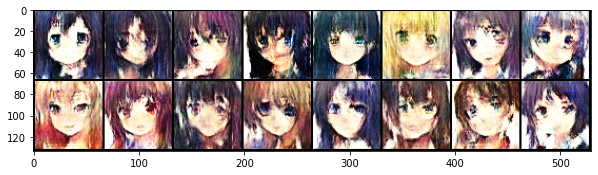

[3999/100000]	Loss_D: -22.4779	Loss_G: 18.8554:   4%|▍         | 3999/100000 [47:17<18:54:02,  1.41it/s]

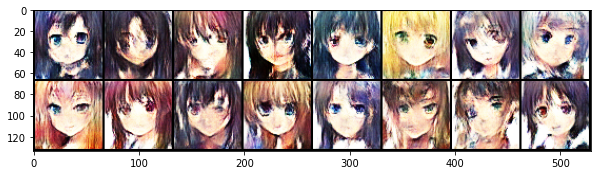

[4999/100000]	Loss_D: -23.9086	Loss_G: 23.5282:   5%|▍         | 4999/100000 [59:07<18:43:49,  1.41it/s]

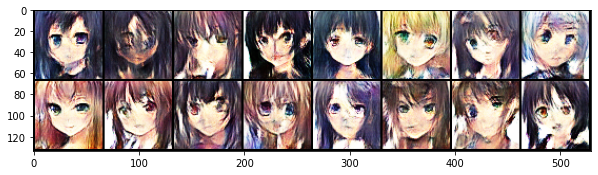

[5999/100000]	Loss_D: -20.7491	Loss_G: 16.7409:   6%|▌         | 5999/100000 [1:10:57<18:30:37,  1.41it/s]

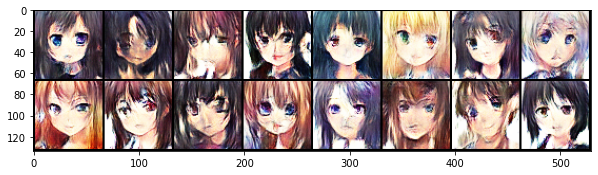

[6999/100000]	Loss_D: -24.3655	Loss_G: 34.2906:   7%|▋         | 6999/100000 [1:22:46<18:18:00,  1.41it/s]

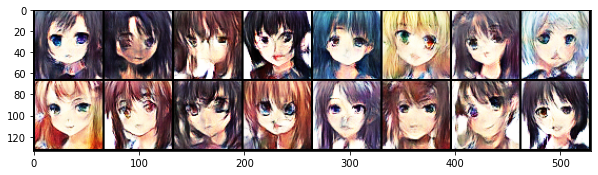

[7999/100000]	Loss_D: -19.5111	Loss_G: 12.5039:   8%|▊         | 7999/100000 [1:34:37<18:12:29,  1.40it/s] 

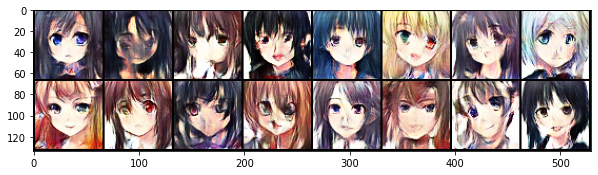

[8999/100000]	Loss_D: -21.5524	Loss_G: 10.8185:   9%|▉         | 8999/100000 [1:46:29<17:55:31,  1.41it/s]

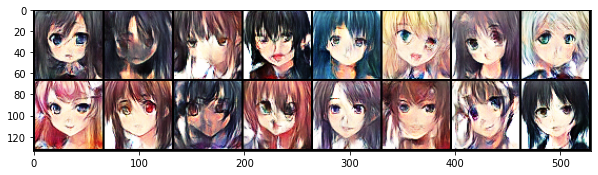

[9999/100000]	Loss_D: -18.5938	Loss_G: 8.1788:  10%|▉         | 9999/100000 [1:58:19<17:45:02,  1.41it/s]  

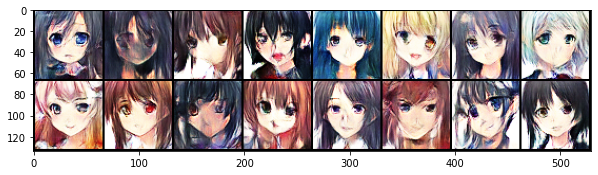

[10999/100000]	Loss_D: -17.2665	Loss_G: 10.4307:  11%|█         | 10999/100000 [2:10:09<17:32:39,  1.41it/s] 

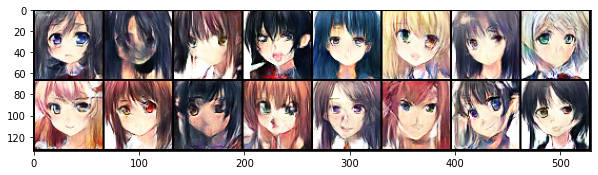

[11999/100000]	Loss_D: -13.8735	Loss_G: 8.1418:  12%|█▏        | 11999/100000 [2:22:00<17:22:02,  1.41it/s] 

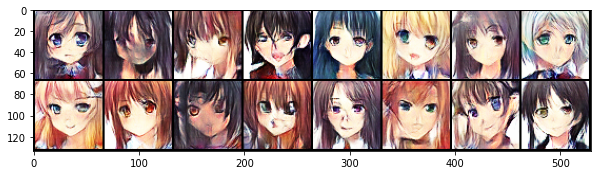

[12999/100000]	Loss_D: -20.8117	Loss_G: 5.9243:  13%|█▎        | 12999/100000 [2:33:50<17:09:28,  1.41it/s]  

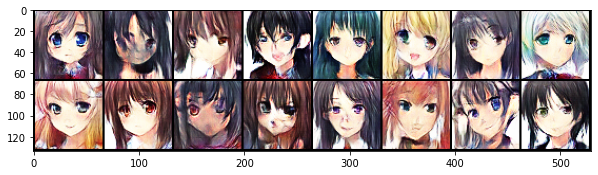

[13999/100000]	Loss_D: -18.9375	Loss_G: 30.8859:  14%|█▍        | 13999/100000 [2:45:42<16:58:34,  1.41it/s] 

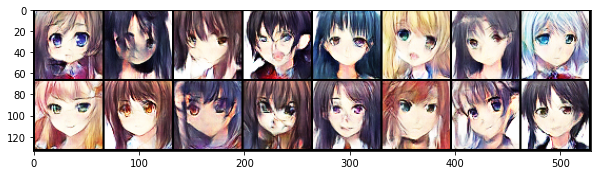

[14999/100000]	Loss_D: -15.9049	Loss_G: 9.3905:  15%|█▍        | 14999/100000 [2:57:32<16:46:16,  1.41it/s]  

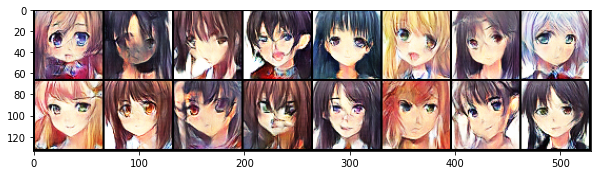

[15999/100000]	Loss_D: -10.6175	Loss_G: 15.4060:  16%|█▌        | 15999/100000 [3:09:22<16:34:25,  1.41it/s]

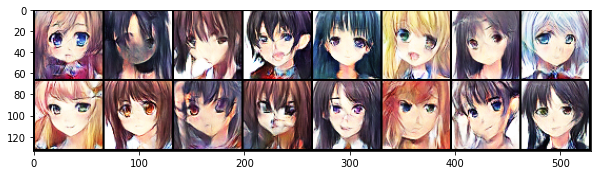

[16999/100000]	Loss_D: -10.2172	Loss_G: 12.6788:  17%|█▋        | 16999/100000 [3:21:13<16:20:37,  1.41it/s]

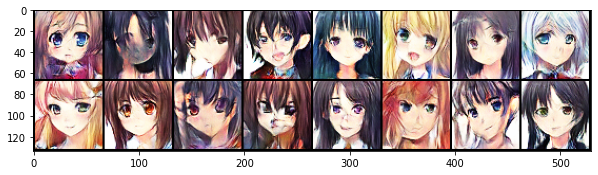

[17175/100000]	Loss_D: -10.6858	Loss_G: 11.9505:  17%|█▋        | 17176/100000 [3:23:18<16:21:08,  1.41it/s]

In [ ]:
def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag

os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1'
seed = random.randint(1, 10000)
random.seed(seed)
torch.manual_seed(seed)

loss = WGAN(gen, dis, device=device)
d_loss = torch.tensor(0)
g_loss = torch.tensor(0)

pbar = tqdm.tqdm(range(num_epochs))

for epoch in pbar:
    try:
        data = next(train_loader)
    except StopIteration:
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        train_loader = iter(train_loader)
        data = next(train_loader)
        
    # 真实数据
    real_images = data.to(device)
    bz = real_images.size(0)

    # 生成数据
    latent_code = torch.randn(bz, nz, 1, 1, device=device)

    # 训练5次判别器之后训练1次生成器
    requires_grad(gen, False)
    requires_grad(dis, True)
    for t in range(5):
        # 训练判别器
        dis.zero_grad()
        d_loss = loss.D_wgan_gp(latent_code, real_images)

        d_loss.backward()
        dis_optimizer.step()

    # 训练生成器
    requires_grad(gen, True)
    requires_grad(dis, False)
    gen.zero_grad()
    
    latent_code = torch.randn(bz, nz, 1, 1, device=device)
    g_loss, _ = loss.G_wgan(latent_code)

    g_loss.backward()
    gen_optimizer.step()

    # loss可视化
    writer.add_scalar('d_loss', d_loss, epoch)
    writer.add_scalar('g_loss', g_loss, epoch)

    state_msg = (
        '[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'% (epoch, num_epochs, d_loss.item(), g_loss.item())
    )
    pbar.set_description(state_msg)
    
    if (epoch+1) % 5000 == 0:
        # 每过5000个epoch更新一次lr
        lr_scheduler_d.step()
        lr_scheduler_g.step()
    
    # 显示生成图像质量
    if (epoch+1) % 1000 == 0:
        with torch.no_grad():
            fake = gen(fixed_noise).detach().cpu()
        img_grid = make_grid(fake, padding=2, normalize=True)
        plt.figure(figsize=(10,10))
        plt.imshow(img_grid.permute(1, 2, 0))
        plt.show()
    
    # 保存模型
    if (epoch+1) % 10000 == 0:
        checkpoint = {
            "g_model_state_dict": gen.module.state_dict(),
            "d_model_state_dict": dis.module.state_dict(),
        }
        path_checkpoint = os.path.join('./checkpoints', "checkpoint_{}_epoch.pkl".format(epoch))
        torch.save(checkpoint, path_checkpoint)